# Notebook to demonstrate:

## Step 0. Inspect HHS data and CovidEstim.org data

## Step 1. Population model being optimized with gradient descent

## Step 2. Population model forecasting hospital-admissions 

## Step 3. Inspect learned parameters with respect to their prior distributions

In [1]:
import datetime
import turicreate as tc
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

%load_ext autoreload
%autoreload 2

from PopulationData import PopulationData
from HospitalData import HospitalData

from PopulationModel import PopulationModel


# Step 0. 
## Inspect the ground-truth data of hospital-admissions that we retrieve from the Health Human Services (HHS) website

 - we define that we want to retrieve data from lookback_date until '20210601' via the HospitalData.py object

 - we will train our model to forecast for the past time period of training_start_date to training_end_date (green shaded in plot)

DOWNLOADING FRESH HHS DATA.........


<ipython-input-2-f27d12dc56bb>:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(range(len(date_xlabels)), labels=date_xlabels, Rotation=90);


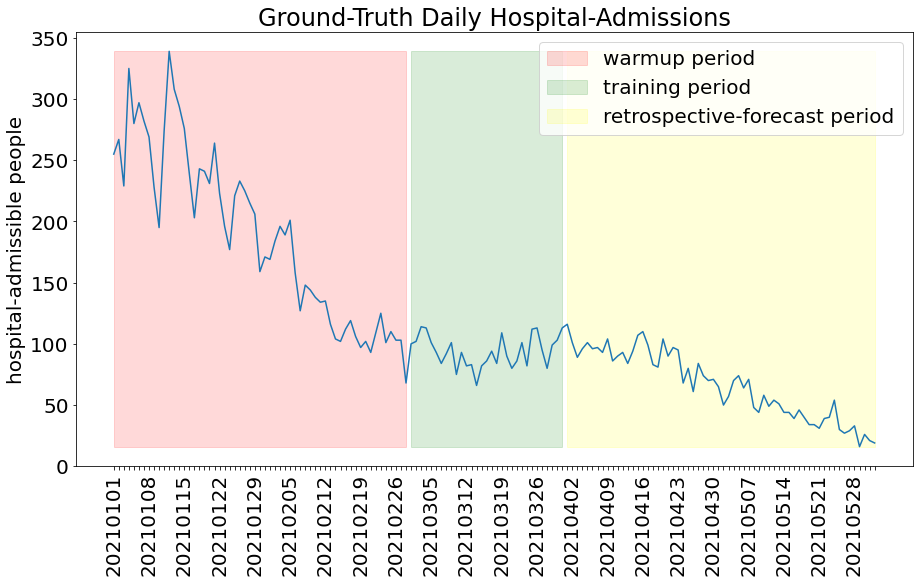

In [2]:
# covidestim_csv = 'covidestim.csv'
state_long = 'Massachusetts'
state_short = 'MA' 

# state_long = 'Minnesota'
# state_short = 'MN' 

results_folder = 'results/'
data_folder = 'data/'

# training_start_date = '20210101'
# training_end_date = '20210401' 

training_start_date = '20210301'
training_end_date = '20210401' 


# ground truth data from a lookback_date to '20210601' to guide model's predictions toward a good fit
lookback_date = '20210101'
hd_truthful = HospitalData('HHS_data_selective.csv', state_short,lookback_date,'20210601')
truthful_Admission_counts = hd_truthful.get_Admission_counts()
plt.figure(figsize=(15,8))    
plt.plot(truthful_Admission_counts);

date_xlabels = [d if i%7 == 0 else '' for i,d in enumerate(hd_truthful.filtered_data['date']) ]
plt.xticks(range(len(date_xlabels)), labels=date_xlabels, Rotation=90);
plt.title('Ground-Truth Daily Hospital-Admissions')
plt.ylabel('hospital-admissible people')
training_end_date_idx = list(hd_truthful.filtered_data['date']).index(training_end_date)
training_start_date_idx = list(hd_truthful.filtered_data['date']).index(training_start_date)

h1 = plt.fill_between(range(training_start_date_idx), min(truthful_Admission_counts), max(truthful_Admission_counts),alpha=0.15, color='red')
h2 = plt.fill_between(range(training_start_date_idx,training_end_date_idx), min(truthful_Admission_counts), max(truthful_Admission_counts),alpha=0.15, color='green')
h3 = plt.fill_between(range(training_end_date_idx,len(truthful_Admission_counts)), min(truthful_Admission_counts), max(truthful_Admission_counts),alpha=0.15, color='yellow')
plt.legend(handles=[h1,h2, h3], labels=["warmup period", "training period", "retrospective-forecast period"])
plt.show()


## Defining the model with the warmup dataset (red-shaded on plot) from covidestim.org

covidestim.org data from lookback_date to the training_start_date will be used to warm up the model 

In other words at timepoint t=training_start_date, values for the compartmental stage Infected ,Symptomatic ,Ailing ,Hospital-admissible are calculated from the following covidestim.org data in the red-shaded time period

ValueError: min() arg is an empty sequence

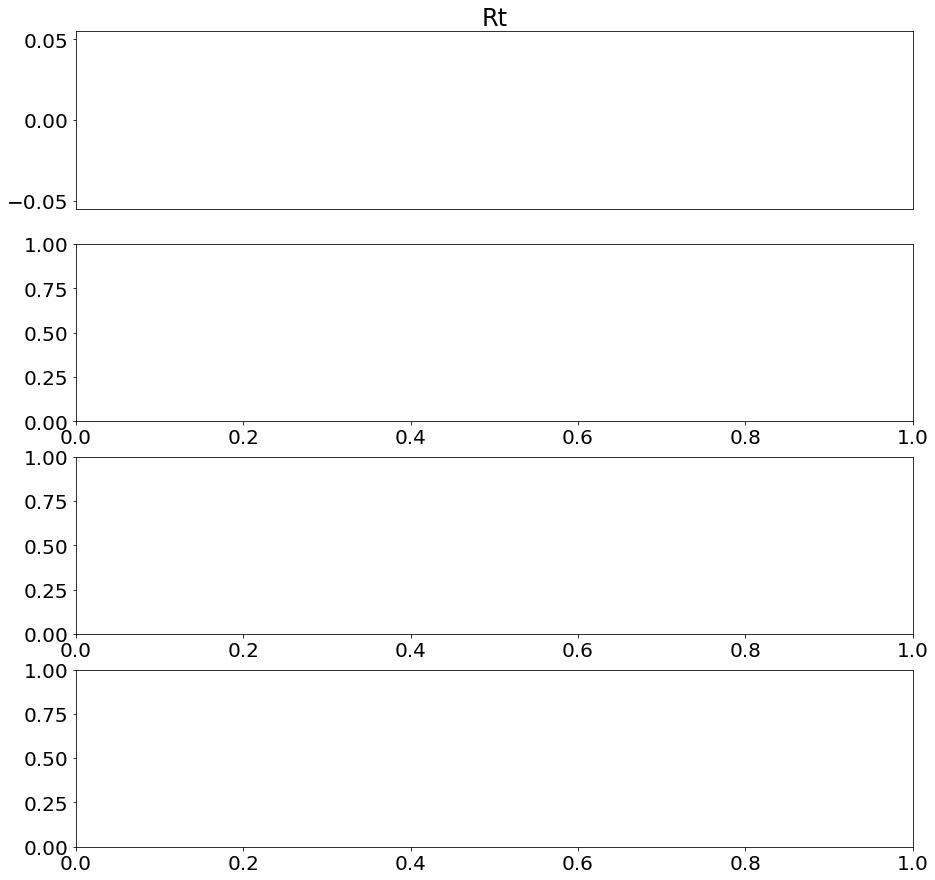

In [3]:

# getting data from covidestim.org
pd_warmup_data = PopulationData(data_folder+"covidestim.csv", state_long, 
                                start_date=lookback_date, end_date=training_start_date);


# print(pop_model.warmup_data.filtered_data)
fig, [warmup_ax1, warmup_ax2, warmup_ax3, warmup_ax4] = plt.subplots(nrows=4, ncols=1,figsize=(15,15))    

x_dates = pd_warmup_data.filtered_data['date']
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]
for e,(i,k) in enumerate(zip([1,2,3,4], ['Rt','infections','symptomatic','ailing'])):
    eval('warmup_ax' +str(i) +'.plot(pd_warmup_data.filtered_data[k])')
    eval('warmup_ax' +str(i) +'.set_title(k)')
    eval('warmup_ax' +str(i)+'.axes.xaxis.set_ticklabels([])')
    eval('warmup_ax' +str(i)+'.set_xticks(range(len(x_dates)))')    
    eval('warmup_ax' +str(i)+'.fill_between(range(training_start_date_idx), min(pd_warmup_data.filtered_data[k]), max(pd_warmup_data.filtered_data[k]),alpha=0.15, color="red")')    
    
plt.xticks(range(len(x_dates)),x_dates, rotation=90);


# Initialzing a population model
pop_model = PopulationModel(warmup_data_obj=pd_warmup_data)


In [5]:
pd_warmup_data.data['state'].unique()

dtype: str
Rows: 34
['Missouri', 'Oregon', 'New Hampshire', 'Georgia', 'Mississippi', 'Kansas', 'South Dakota', 'Delaware', 'Hawaii', 'Wisconsin', 'Tennessee', 'Utah', 'New Mexico', 'Puerto Rico', 'Louisiana', 'Vermont', 'Arkansas', 'Nebraska', 'Oklahoma', 'West Virginia', 'Maine', 'Alaska', 'Nevada', 'North Carolina', 'California', 'Idaho', 'Washington', 'Minnesota', 'Iowa', 'Kentucky', 'Montana', 'Wyoming', 'Alabama', 'North Dakota']

# Step 1.
## Fit the model to a given training dataset from HHS hospital admissions

In [4]:
training_data_obj = HospitalData('HHS_data_selective.csv', state_short, start_date=training_start_date,end_date=training_end_date)
pop_model.fit(training_data_obj, 
              n_iters=12, step_size_txn=5e-5, step_size_soj=9e-5, n_steps_between_print=5, lambda_reg=1e-3, plots=True)

NameError: name 'pop_model' is not defined

## See how gradient descent did in terms of reducing the loss function over each iteration

In [ ]:
fig, [train_ax1, train_ax2] = plt.subplots(nrows=2, ncols=1,figsize=(15,10))    

train_ax1.plot(pop_model.loss_per_iter, label='loss')
train_ax1.set_title('training loss (+regularization)')
train_ax1.legend()
train_ax1.grid()

for k,v in pop_model.gradients_per_iter.items():
    if k in ['prob_sympt_s',
                'prob_ailing_s',
                'prob_hosp_s',
                'prob_soujourn_inf_alpha_s',
                'prob_soujourn_inf_beta_s',
                'prob_soujourn_symp_alpha_s',
                'prob_soujourn_symp_beta_s']:
        train_ax2.plot(v,label=k)

train_ax2.legend()
train_ax2.grid()
train_ax2.set_ylabel('gradients')
train_ax2.set_xlabel('iteration')
plt.show()


# Step 2.
## Use the optimized/learned pop_model.params to forecast beyond the training dates

setting save_admissions = True will generate forecasted_admissions.csv

In [ ]:
pop_model.training_mode=False
pop_model.warmup_data.end_date = training_end_date
pop_model.forecast_duration=60

print(pop_model.params)
plt.figure(figsize = (15,7))


training_hospitalizations = list(training_data_obj.get_Admission_counts())
forecasted_hospitalizations = list(pop_model.get_forecasted_data(save_admissions=False)['hospitalized']) 
training_forecasted_hospitalizations = training_hospitalizations + forecasted_hospitalizations
hd_observed = HospitalData('HHS_data_selective.csv', state_short,training_start_date,'20210610')
hd_observed_hospitalizations = list(hd_observed.get_Admission_counts())                                   

plt.plot(hd_observed_hospitalizations, label= 'HHS ground truth', linewidth=5)
plt.plot(training_forecasted_hospitalizations,label='training data + forecast', linestyle='--' )


min_val  = min(training_forecasted_hospitalizations+hd_observed_hospitalizations)
max_val  = max(training_forecasted_hospitalizations+hd_observed_hospitalizations)
plt.fill_between(range(len(training_hospitalizations)), min_val, max_val,
                 alpha=0.15, color='green')
plt.fill_between(range(len(training_hospitalizations),len(training_forecasted_hospitalizations)), min_val, max_val,
                alpha=0.15, color='yellow')

                                                                                                                                      
x_dates=list(hd_observed.filtered_data['date'])
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]                                                                                                                                      
plt.xticks(range(len(x_dates)),x_dates, rotation=90 );
plt.ylabel('hospital-admissible people')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# pop_model.get_forecasted_data()['Rt']

# Forecasting beyond today

In [ ]:
pop_model.training_mode=False
pop_model.warmup_data.end_date = '20210610'
pop_model.forecast_duration=60

print(pop_model.params)
plt.figure(figsize = (15,7))


# training_hospitalizations = list(training_data_obj.get_Admission_counts())
forecasted_hospitalizations = list(pop_model.get_forecasted_data(save_admissions=True)['hospitalized']) 
# training_forecasted_hospitalizations = training_hospitalizations + forecasted_hospitalizations
hd_observed = HospitalData('HHS_data_selective.csv', state_short,training_start_date,pop_model.warmup_data.end_date)
hd_observed_hospitalizations = list(hd_observed.get_Admission_counts())                                   

plt.plot(hd_observed_hospitalizations, label= 'HHS ground truth', linewidth=5)
plt.plot(hd_observed_hospitalizations + forecasted_hospitalizations,label='forecast', linestyle='--' )


min_val  = min(hd_observed_hospitalizations + forecasted_hospitalizations)
max_val  = max(hd_observed_hospitalizations + forecasted_hospitalizations)

plt.fill_between(range(len(hd_observed_hospitalizations),len(hd_observed_hospitalizations + forecasted_hospitalizations)), min_val, max_val,
                alpha=0.15, color='yellow')

                                                                                                                                      
x_dates=list(hd_observed.filtered_data['date'])
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]                                                                                                                                      
plt.xticks(range(len(x_dates)),x_dates, rotation=90 );
plt.ylabel('hospital-admissible people')
plt.legend()
plt.grid()
plt.show()

# Step 3. 
## Inspect the learned parameters with respect to their given prior distributions

# At the time of forecasting, Rt values are approximated with linear interpolation


In [ ]:
import numpy as np

pd_estim_data = PopulationData(data_folder+"covidestim.csv", state_long,lookback_date, end_date=str(pop_model.get_dates_to_forecast()[-1]));
days_before_Rt_interpolation = (len(pd_estim_data.filtered_data['Rt']) - pop_model.forecast_duration)

plt.figure(figsize=(15,5))
plt.plot(pd_estim_data.filtered_data['Rt'], label='CovidEstim.org estimated Rt')
plt.plot(([np.nan]*days_before_Rt_interpolation) +  list(pop_model.get_forecasted_data()['Rt']), label='forecasting w/ Rt interpolated');

x_dates = pd_estim_data.filtered_data['date']
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]   
plt.xticks(range(len(x_dates)),x_dates, rotation=90)

plt.fill_between(range((days_before_Rt_interpolation),len(x_dates)), 
                 min(pd_estim_data.filtered_data['Rt']), max(pd_estim_data.filtered_data['Rt']),
                alpha=0.15, color='yellow')

plt.fill_between(range((days_before_Rt_interpolation-(pop_model.training_data.filtered_data.num_rows())),(days_before_Rt_interpolation)), 
                 min(pd_estim_data.filtered_data['Rt']), max(pd_estim_data.filtered_data['Rt']),
                alpha=0.15, color='green')
plt.legend()
# plt.grid()


In [ ]:
# pd_list_train[0].end_date = '20210501'
pd_list_train[0].end_date = '20210801'
pd_list_train[0].get_forecasted_data(new_params, save_admissions=True) 

In [ ]:
if not RELOADING_RESULTS: # save newly learned results
    import pickle
    filename = results_folder+state_short + '_population_params_trained_on_'+str(training_end_date)+'_'+str(training_end_dates[0])
    with open(filename+'.pickle', 'wb') as handle:
        pickle.dump(new_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(filename+'.pickle', 'rb') as handle:
        b = pickle.load(handle)

    print (new_params == b)
    print(new_params)

In [ ]:
## TODO consider plotting the prior distrobutions and consider plotting posterior distribution

import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

prior_params_ab = {'prob_sympt_s':[5.5,2],'prob_severe_s':[2,5],'prob_hosp_s':[2,4]}

        
for k,v in prior_params_ab.items():
    a = v[0]
    b = v[1]
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
#     print(mean,'*mean value given a,b*', a,b)
#     print(var,'*var value given a,b*', a,b)
    print(sigmoid(new_params[k]), 'optimized param', k)

    x = np.linspace(0,1,1000)
    pdf_vals = beta.pdf(x, a, b)
    imax = np.argmax(pdf_vals)
    print(x[imax],'*mode value given a,b*', a,b)
    plt.plot(x, pdf_vals,
           'k-', lw=5, label=k+' beta prior')
#     plt.vlines(sigmoid(new_params[k]),np.min(pdf_vals),beta.pdf(sigmoid(new_params[k]), a, b), label='optimized '+ k)

#     plt.legend(loc='best', frameon=False)

    plt.grid()
    plt.savefig(results_folder+state_short+'_prior_'+ k+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
    plt.show()
    

In [ ]:
import numpy as np
from scipy.stats import gamma
# import matplotlib.pyplot as plt
import math
qfn = lambda a,b,c: [(-b + math.sqrt(b**2 - (4*a*c) )) / (2 * a),(-b - math.sqrt(b**2 - (4*a*c) )) / (2 * a)]

            # self.params['prob_soujourn_inf_alpha']= 3.41
    # self.params['prob_soujourn_inf_beta']= 0.605
    # self.params['prob_soujourn_symp_alpha']= 1.62
    # self.params['prob_soujourn_symp_beta']= 0.218
soj_new_params = [softplus(new_params['prob_soujourn_inf_alpha_s']),softplus(new_params['prob_soujourn_inf_beta_s']),
                  softplus(new_params['prob_soujourn_symp_alpha_s']),softplus(new_params['prob_soujourn_symp_beta_s'])
                 ]
soj_param_names = ['prob_soujourn_inf_alpha_s','prob_soujourn_inf_beta_s','prob_soujourn_symp_alpha_s','prob_soujourn_symp_beta_s']
for i,mode_value in enumerate([3.41,0.605,1.62,0.218]):
# for i,mode_value in enumerate([3.41,0.605,1.62,0.23]):
    betas = qfn(4,-mode_value,-1)
    beta = max(betas)

    a = 4*beta**2

    print(a,beta, 'a,b')
    print(soj_new_params[i], '= optimized', soj_param_names[i])

#     fig, ax = plt.subplots(1, 1)
    x = np.linspace(0,15, 1000)
    rv = gamma(a,scale=1/beta)
    pdf_vals = rv.pdf(x)
    imax = np.argmax(pdf_vals)
    
    plt.plot(x, pdf_vals, 'k-', lw=5, label='gamma prior')
    print('mode value = ' + str(x[imax]) + ' vs opt ' + str(soj_new_params[i]))
#     plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')

#     plt.legend(loc='best', frameon=False)
#     plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
    plt.grid()
    plt.savefig(results_folder+state_short+'_prior_'+ soj_param_names[i]+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
    plt.show()
    
    print('------')

In [ ]:
import os

import numpy as np


from scipy.special import gamma as gamma_fcn
from autograd_gamma import gammainc

from scipy.special import expit as sigmoid
from scipy.special import logit as sigmoid_inv
softplus = lambda x: np.log(1+np.exp(x))

softplus_inv = lambda x: np.log(np.exp(x) -1)
def log_gamma_pdf(x,alpha,beta):
    return alpha*np.log(beta) + (alpha-1)*np.log(x) - (beta*x) - np.log(gamma_fcn(alpha))

def gamma_at_x(params,x):
    if x==0:
        return 0.0 
    if x==1:
        return cdf_at_x(params,x)
    elif x>1:
        return cdf_at_x(params,x) - cdf_at_x(params,x-1)

def cdf_at_x(params,x):
    return (gammainc(params['alpha'],params['beta']*x))



In [ ]:
            # self.params['prob_soujourn_inf_alpha']= 3.41
    # self.params['prob_soujourn_inf_beta']= 0.605
    # self.params['prob_soujourn_symp_alpha']= 1.62
    # self.params['prob_soujourn_symp_beta']= 0.218
from matplotlib.pyplot import stem
########## INF SOJOURN
a = softplus(new_params['prob_soujourn_inf_alpha_s'])
beta = softplus(new_params['prob_soujourn_inf_beta_s'])
x = np.linspace(1,40, 40)
rv = gamma(a,scale=1/beta)
rv0 = gamma(3.41,scale=1/.605)

# plt.plot(x, rv.pdf(x), 'r-', lw=5, label='inf soj posterior')
# plt.plot(x, rv0.pdf(x), 'k-', lw=5, label='inf soj prior pdf')

stem(x, [gamma_at_x({'alpha':3.41,'beta':.605},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':a,'beta':beta},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
# plt.bar(x,[gamma_at_x({'alpha':a,'beta':beta},val) for val in x])
# plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')
plt.title('I-Sojourn-PMF')
plt.legend(loc='best', frameon=False)
# plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
plt.grid()
plt.savefig(results_folder+state_short+'_MAP_'+ '_I-Sojourn-PMF_'+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
plt.show()
        
        
########## SYMP SOJOURN
                  
                  
a = softplus(new_params['prob_soujourn_symp_alpha_s'])
beta = softplus(new_params['prob_soujourn_symp_beta_s'])

x = np.linspace(1,40, 40)
rv = gamma(a,scale=1/beta)
rv0 = gamma(1.62,scale=1/.218)

# plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='symp soj posterior')
# plt.plot(x, rv0.pdf(x), 'k:', lw=3, label='symp soj prior')
# plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')
stem(x, [gamma_at_x({'alpha':1.62,'beta':.218},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':a,'beta':beta},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
plt.title('S-Sojourn-PMF')

plt.legend(loc='best', frameon=False)
# plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
plt.grid()
plt.savefig(results_folder+state_short+'_MAP_'+ '_S-Sojourn-PMF_'+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
plt.show()